**Vision Transformer**

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3685, done.
remote: Counting objects: 100% (307/307), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 3685 (delta 158), reused 286 (delta 145), pack-reused 3378
Receiving objects: 100% (3685/3685), 648.09 MiB | 24.11 MiB/s, done.
Resolving deltas: 100% (2114/2114), done.
Updating files: 100% (247/247), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**Get data**

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

**Pre Processing Data**

In [6]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}") 

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff63ace2c10>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[1], label_batch[1]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

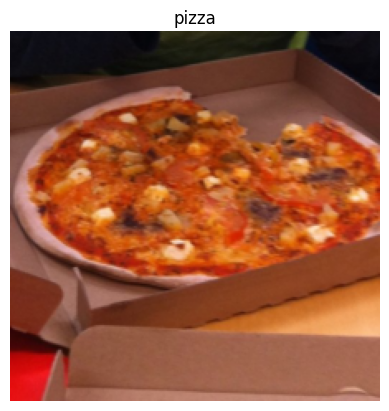

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

**Make patch Embedding layer**

In [10]:
rand_image_tensor = torch.randn(32,3,224,224)  # in pytorch, the color channel  comes first
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [11]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [12]:
patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"input share: {rand_image_tensor.shape}")
print(f"output shape: {patch_embedding_output.shape} -->(batch_size, num_patches, embedding_dim)")

input share: torch.Size([32, 3, 224, 224])
output shape: torch.Size([32, 196, 768]) -->(batch_size, num_patches, embedding_dim)


**Transformer Encoder Layer**

In [13]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model= 768,
                                                       nhead = 12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first =True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [14]:
from torchinfo import summary

summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 19.27
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 19.27

In [15]:
## stack Transformer Encoder layer on top of each other to build full encoder layer

In [16]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer =transformer_encoder_layer,
    num_layers=12)

transformer_encoder

TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [17]:
##summery of transformer_encoder
summary(model=transformer_encoder,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [32, 196, 768]            --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-2      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-3      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-4      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-5      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-6      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-7      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-8      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-9      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-10     [32, 196, 768]            7,087,872
│    └─Transfor

In [18]:
class ViT(nn.Module):
  def __init__(self,
               img_size = 224,
               num_channels=3,
               patch_size =16,
               embedding_dim=768,
               dropout=0.1,
               mlp_size=3072,
               num_transformer_layers=12,
               num_heads=12,
               num_classes=1000):
    super().__init__()


    ## Assert image size is devisible by patch size

    assert img_size % patch_size == 0, "image size must be divisble by patch size"

    #1. create patch Embedding

    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)
    
    #2. Create class token

    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                    requires_grad=True)
    
    #3. Create positional embedding

    num_patches = (img_size * img_size) // patch_size**2 # N = HW/p^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    #4. create patch + positional embedding drpout

    self.embedding_dropout = nn.Dropout(p=dropout)

    #5. create Transformer Encoder layer(single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)
    #6. Create stack Transformer Encoder layer (stacked single layer)
    self.transofrmer_encoder = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                nhead=num_heads,
                                                                                                dim_feedforward=mlp_size,
                                                                                                activation="gelu",
                                                                                                batch_first=True,
                                                                                                norm_first=True), #create single Transformer Encoder layer
                                                     num_layers=num_transformer_layers) #stack it N times
    
    #7 create MLP head

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self,x):

    #get some dimentions from x

    batch_size = x.shape[0]

    #Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    #First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) ##-1 means infer the dimensic

    #prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    #add the positional embedding to patch embedding with class token

    x = self.positional_embedding + x
    # print(x.shape)

    #dropout on patch = positional embedding
    x = self.embedding_dropout(x)

    #pass embedding through Transformer encoder stack
    x = self.transofrmer_encoder(x)

    #pass 0th index of the x through MLP head

    x = self.mlp_head(x[:, 0])

    return x


In [19]:
demo_img = torch.randn(1,3,224,224)
# print(demo_img.shape)

#create Vit
vit = ViT(num_classes = len(class_names))
vit(demo_img)

tensor([[ 0.1225, -0.0797,  0.5152]], grad_fn=<AddmmBackward0>)

In [20]:
len(class_names)

3

In [21]:
#summery of ViT

summary(model=ViT(num_classes=1000),
        input_size=demo_img.shape)

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [22]:
## Checking Class token

embedding_dim =768
class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                           requires_grad = True)
class_token.requires_grad

True

In [23]:
## check positional embedding
patch_size = 16
img_size = 224
num_patches = (img_size * img_size) // patch_size **2
pos_embedding = nn.Parameter(torch.randn(1,num_patches+1,embedding_dim))
pos_embedding.shape

torch.Size([1, 197, 768])

**Trun the custom ViT architecture we created into a python script, for example vit.py**
that we can import entire ViT model using something like "from vit import ViT"

In [24]:
## example
%%writefile example.py
print("hello world I am vit.py!")

Writing example.py


In [25]:
!python example.py

hello world I am vit.py!


To do that, we have to copy all vit model dependencies to a single cell and write it to file using the magic '%writefile FILENAME'.

In [26]:
%%writefile vit.py

import torch
from torch import nn


# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

class ViT(nn.Module):
  def __init__(self,
               img_size = 224,
               num_channels=3,
               patch_size =16,
               embedding_dim=768,
               dropout=0.1,
               mlp_size=3072,
               num_transformer_layers=12,
               num_heads=12,
               num_classes=1000):
    super().__init__()


    ## Assert image size is devisible by patch size

    assert img_size % patch_size == 0, "image size must be divisble by patch size"

    #1. create patch Embedding

    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)
    
    #2. Create class token

    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                    requires_grad=True)
    
    #3. Create positional embedding

    num_patches = (img_size * img_size) // patch_size**2 # N = HW/p^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    #4. create patch + positional embedding drpout

    self.embedding_dropout = nn.Dropout(p=dropout)

    #5. create Transformer Encoder layer(single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)
    #6. Create stack Transformer Encoder layer (stacked single layer)
    self.transofrmer_encoder = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                nhead=num_heads,
                                                                                                dim_feedforward=mlp_size,
                                                                                                activation="gelu",
                                                                                                batch_first=True,
                                                                                                norm_first=True), #create single Transformer Encoder layer
                                                     num_layers=num_transformer_layers) #stack it N times
    
    #7 create MLP head

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self,x):

    #get some dimentions from x

    batch_size = x.shape[0]

    #Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    #First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) ##-1 means infer the dimensic

    #prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    #add the positional embedding to patch embedding with class token

    x = self.positional_embedding + x
    # print(x.shape)

    #dropout on patch = positional embedding
    x = self.embedding_dropout(x)

    #pass embedding through Transformer encoder stack
    x = self.transofrmer_encoder(x)

    #pass 0th index of the x through MLP head

    x = self.mlp_head(x[:, 0])

    return x


Writing vit.py


In [27]:
!python vit.py

In [28]:
from vit import ViT
imported_vit = ViT()
summary(model=imported_vit,
        input_size =(1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

**Train a pretrained ViT feature Extractor model on 20% of the pizza, steak and sushi data.**

In [29]:
#create vit feature extractor model

import torchvision

#download pretrained vit weights and model

vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT #Default means best available weights
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)
pretrained_vit

# Freeze all layers in preptrained ViT model

for param in pretrained_vit.parameters():
  param.requires_grad = False

#update the pretrained vit head
embedding_dim = 768
set_seeds()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

# Get a summary
summary(model=pretrained_vit,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable" ],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:08<00:00, 38.5MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [30]:
## get 20% os the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

#setup train and test directories

train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test"   ''' no need test data, cz we will keep the test data same but the train data will be different'''

#preprocess the data

vit_transforms = vit_weights.transforms()  # get Transforms from vit_weights

train_data_loader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                           test_dir=test_dir,
                                                                                           transform=vit_transforms,
                                                                                           batch_size=1024)

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [31]:
len(train_dataloader), len(train_data_loader_20_percent),len(test_dataloader)

(8, 1, 1)

In [32]:
## train a pretrained vit feature extractor

# from going_moduler.going_moduler import engine

set_seeds()

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_data_loader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2183 | train_acc: 0.2333 | test_loss: 1.0267 | test_acc: 0.4933
Epoch: 2 | train_loss: 0.9652 | train_acc: 0.5222 | test_loss: 0.8170 | test_acc: 0.6267
Epoch: 3 | train_loss: 0.7699 | train_acc: 0.7333 | test_loss: 0.6600 | test_acc: 0.7200
Epoch: 4 | train_loss: 0.6225 | train_acc: 0.8244 | test_loss: 0.5423 | test_acc: 0.7867
Epoch: 5 | train_loss: 0.5119 | train_acc: 0.8711 | test_loss: 0.4536 | test_acc: 0.8667
Epoch: 6 | train_loss: 0.4290 | train_acc: 0.8867 | test_loss: 0.3865 | test_acc: 0.8800
Epoch: 7 | train_loss: 0.3668 | train_acc: 0.9044 | test_loss: 0.3357 | test_acc: 0.8933
Epoch: 8 | train_loss: 0.3199 | train_acc: 0.9156 | test_loss: 0.2973 | test_acc: 0.8933
Epoch: 9 | train_loss: 0.2841 | train_acc: 0.9200 | test_loss: 0.2680 | test_acc: 0.9200
Epoch: 10 | train_loss: 0.2564 | train_acc: 0.9244 | test_loss: 0.2457 | test_acc: 0.9333


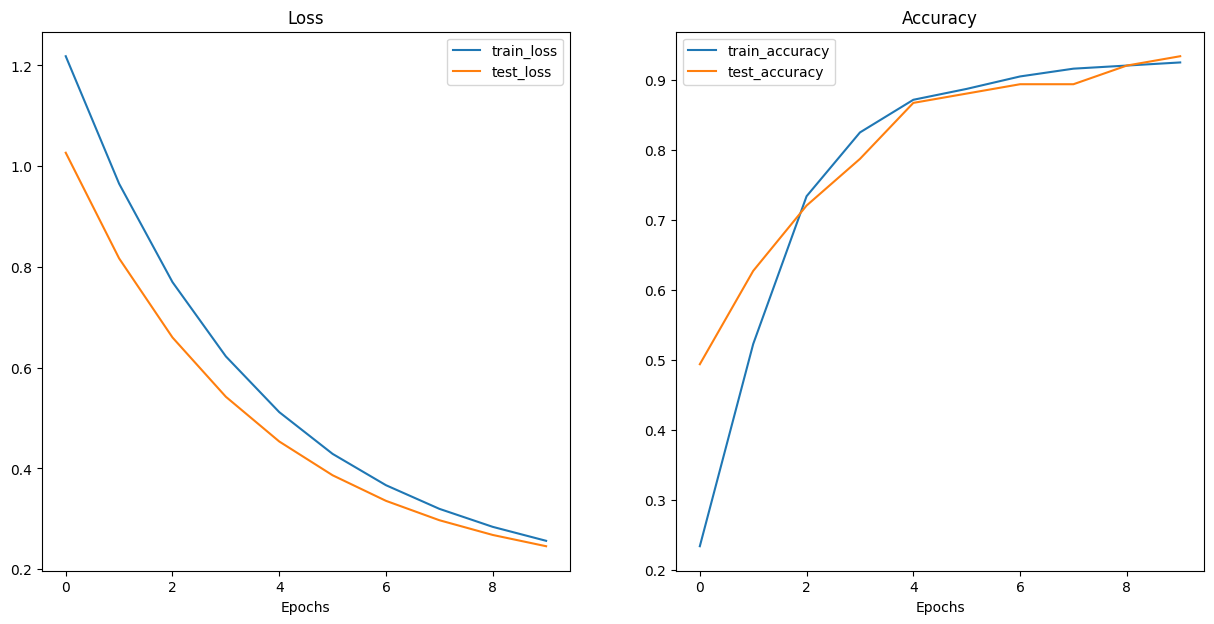

In [33]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

Try the same pre-trained method as before but with different pretrained wright -SWAG which is unlabeled dataset.

In [34]:
#create vit feature extractor model

import torchvision

#download pretrained vit weights and model

vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 #Default means best available weights
pretrained_vit_swag = torchvision.models.vit_b_16(weights=vit_weights_swag)
pretrained_vit_swag

# Freeze all layers in preptrained ViT model

for param in pretrained_vit_swag.parameters():
  param.requires_grad = False

#update the pretrained vit head
embedding_dim = 768
set_seeds()
pretrained_vit_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

# Get a summary
summary(model=pretrained_vit_swag,
        input_size=(1,3,384,384),  ## the minimum input size of ViT swag
        col_names=["input_size", "output_size", "num_params", "trainable" ],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:05<00:00, 64.0MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [35]:
#checkout transforms
vit_transforms_swag = vit_weights.transforms()  # get Transforms from vit_weights_swag
vit_transforms_swag

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [36]:
## get 20% os the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

#setup train and test directories

train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test"   ''' no need test data, cz we will keep the test data same but the train data will be different'''

#preprocess the data

# vit_transforms_swag = vit_weights.transforms()  # get Transforms from vit_weights

train_data_loader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                           test_dir=test_dir,
                                                                                           transform=vit_transforms,
                                                                                           batch_size=32)

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [37]:
## train a pretrained vit feature extractor with swag weights

# from going_moduler.going_moduler import engine

set_seeds()

optimizer_swag = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_swag_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_data_loader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3156 | train_acc: 0.9104 | test_loss: 0.1891 | test_acc: 0.9280
Epoch: 2 | train_loss: 0.1269 | train_acc: 0.9667 | test_loss: 0.1989 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.0954 | train_acc: 0.9750 | test_loss: 0.1860 | test_acc: 0.9688
Epoch: 4 | train_loss: 0.0673 | train_acc: 0.9812 | test_loss: 0.1768 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.0589 | train_acc: 0.9833 | test_loss: 0.1778 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.0613 | train_acc: 0.9896 | test_loss: 0.1743 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.0449 | train_acc: 0.9938 | test_loss: 0.1836 | test_acc: 0.9583
Epoch: 8 | train_loss: 0.0387 | train_acc: 0.9979 | test_loss: 0.2006 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.0468 | train_acc: 0.9979 | test_loss: 0.2012 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0287 | train_acc: 1.0000 | test_loss: 0.1915 | test_acc: 0.9583


Thank you.